### Candidate numbers: 39208 and 32093

# Introduction
Before recent computational advancements, financial time series models were either stochastic processes or agency based, where stochastic models assume that fluctuations in stock prices are driven by an Ito process, and agency based models describe an agent's behaviour and interactions with other agent's based on empiracally observed assumptions. Therefore, both types of models require different levels of parameters and intuition to accurately describe the observed characteristics of financial time series.

Hence, it is desirable to develop an alternative approach that can reproduce the financial time-series characteristics without an implicit amount of built-in assumptions. This is where deep learning comes in, as we will be utilising the FinGAN model presented by Takahashi et al. which will learn the properties of the financial time series in a data-driven way by generating a synthetic series that exhibits the observed characteristics, which we will test later in the project.

We also plan to investigate the generation of financial time series using the TimeGAN model proposed by Yoon, Jarrett and van der Schaar. The generation of financial time series introduces an additional complexity compared to the generation of images, which is the problem GANs were designed to solve (Goodfellow et al., 2014). The image generation task does not explicitly require capturing conditional distributions $p(\boldsymbol{x}_t \mid \boldsymbol{x}_{1:t-1})$, given sequential time-series data of the form $\boldsymbol{x}_{1:t} = (x_1, \dots, x_t)$; instead, image generation only requires learning a joint distribution of the form $p(\boldsymbol{x}_{1:t})$. In other words, traditional GANs such as FinGAN learn the distribution of features *within* each time point by treating the time-series as a random vector and learning its joint probability distribution, but they do not necessarily learn the distribution of features *between* time points. The TimeGAN model seeks to address this deficiency, by explicitly learning the conditional distributions $p(\boldsymbol{x}_t \mid \boldsymbol{x}_{1:t-1})$ present in the data. The authors did not specifically seek to model financial time series, but they find that the feature of TimeGAN is particularly helpful for generated stock price data, which tend to have high serial correlation.
 
Aside from being an interesting problem from the perspective of deep learning, we mention but two examples of applications of a generative model for financial time series. If we can generate realistic prices, we can use these to train neural network option pricing models, instead of, for example, having to obtain real option price data or sampling synthetic price paths from a geometric Brownian motion. Another application can be as a market scenario generator. If we can generate realistic price series for a number of different assets which also captures interactions between those assets, or if we can generate time series of economic variables such as GDP, unemployment and inflation, then we are able to generate realistic market scenarios to further economic understanding or e.g. perform stress tests.

To briefly summarise our findings, we found that the FinGAN has a slightly unstable loss path while training for the chosen number of epochs. TimeGAN trains fairly smoothly, with the generator learning quickly in the first few epochs but very little in the remaining epochs. The generated data for FinGAN does not exhibit the empirically observed characteristics, but TimeGAN seems to be able to generate time series which exhibit volatility clustering. We found that the FinGAN's generator performed better than the TimeGAN's, as measured by JS-Divergence between real data and the data generated by each model. 

The remainder of this report is structured as follows. We first present our choice of training data, and provide a description of its properties. In particular, we discuss some of the characteristics of financial time-series which are mentioned by in the FinGAN paper. After describing data-preprocessing steps, we discuss the architecture of the FinGAN and TimeGAN models. Then, we train both of these models, and evaluate the quality of synthetic financial time series generated by them. Finally, we conclude by discussing some directions for future research. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l


from d2l import torch as d2l
from sklearn.preprocessing import MinMaxScaler

from torchsummary import summary
import random
from sklearn.manifold import TSNE 

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)
torch.manual_seed(0);

# Data
As we require a large time series of financial returns, we will be using a dataset of individual S&P500 stocks from the past 5 years, [which we found on Kaggle here](https://www.kaggle.com/datasets/camnugent/sandp500). The dataset has a total of 619039 daily observations of opening price, highest price, lowest price, closing price, trading volume and tickers, and we decided to choose this specific data set for two reasons: 

- 1) It is used in the FinGAN paper
- 2) The S&P500 contains the highest market cap stocks that have the highest trading volumes, hence large fluctuations in returns

In [ ]:
# Import s&p500 data and obtain log returns:
df = pd.read_csv('all_stocks_5yr.csv)
# Create log return column
# used below to visualise financial time series characteristcs
df['log_r'] = np.log(df.close) - np.log(df.close.shift(1))
df = df.dropna()

### Financial Time Series Characteristics
To make sure that the time series data that we will use to train FinGAN is appropriate, we will show that the data exhibits volatility clustering and heavy tails. As this project is intended to test our AI knowledge, we will not be showing the other characteristics, as the two that we have chosen are the most important in determining if our data displays the empirical findings.

It is also useful to note that we cannot use the entire sample length of data (619039 observations) as the returns have not been scaled between different stocks, hence the characteristics displayed would not be accurate. Therefore, we will use the data only for the first stock in the dataset (AAL) with the full sample length of 1259 trading days as the return time series to display the characteristics.

#### Volatility Clustering
Volatility Clustering is when the conditional volatility of financial returns exhibits cyclical patterns (strong autocorrelation). In more simple terms, it means that large changes tend to be followed by large changes, and small changes tend to be followed by small changes. To see this visually, we can see that the log return "spikes" cluster together and tend to persist as a function of trading days.

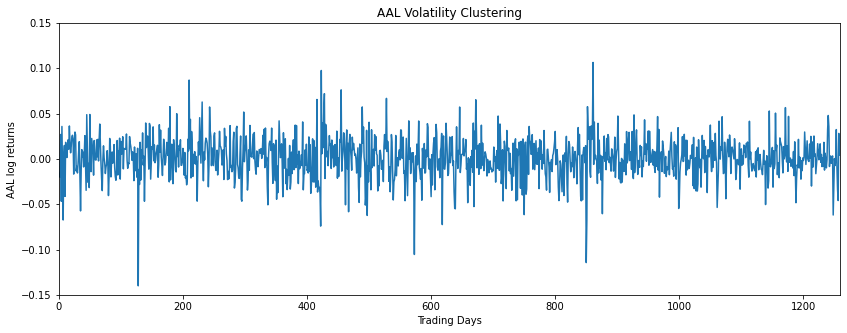

In [ ]:
df_AAL = df[0:1258]  # Select data for first stock (AAL)  

# Plot AAL log returns as fnc of trading days
plt.plot(df_AAL["log_r"])
plt.ylabel('AAL log returns')
plt.xlabel('Trading Days')
plt.title('AAL Volatility Clustering')
plt.ylim(-0.15,0.15)
plt.xlim(0, 1259)
plt.show()

#### Heavy Tails
Heavy Tails refers to the fact when financial returns time series has more observations with extreme returns and closer to the zero mean than predicted by a normal distribution with the sample mean and standard deviation. Obserbing the QQplot, we can see that the AAL log returns (blue dots) deviate from what would be implied under a normal distribution (red line). Therefore, the AAL log returns time series exhibits fatter tails compared to a normal distribution (Kurtosis >3)

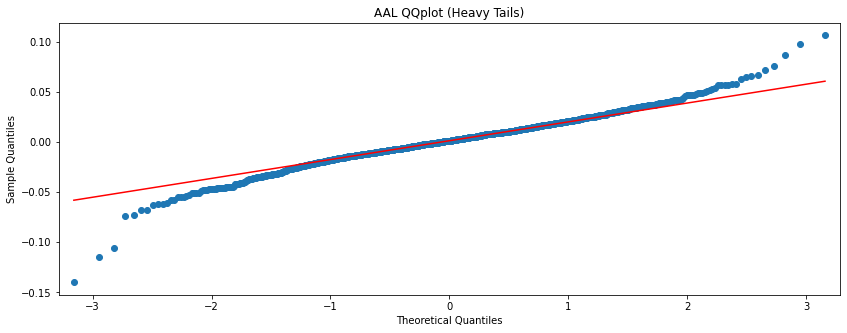

In [ ]:
# Plot QQplot for AAL log returns
fig = sm.qqplot(df_AAL["log_r"], line='q')
plt.title('AAL QQplot (Heavy Tails)')
plt.show()

### Data preprocessing

Ideally, we would be able to use each time series of length 1259 to train FinGAN. However, we want to compare FinGAN with TimeGAN, which cannot generate such long time series without significant computing power. Hence, we choose to generate time series of length 255 instead. This number was chosen since it is the number of trading days in one year, and should still be long enough to observe volatility clustering and heavy tails. 255 is significantly longer than the length of time series generated by the TimeGAN author's implementation on GitHub; they only generate time series of length 24.

#### Cleaning
We clean the dataset by first selecting stocks with exactly 1259 trading days worth of data, since some stocks have fewer trading days of data. Then, we only keep data for the first six stocks, since the authors of the TimeGAN paper used a 6-variate time series in their experiements with stock data. Using data for significantly more stocks would result in TimeGAN having a huge number of estimable parameters, which again requires a lot of computing power. Again, as we would like to compare the FinGAN with TimeGAN, we use the same data for FinGAN. The tensor has shape (1259,6), corresponding to close price series for six stocks, each of length 1259. 

In [ ]:
# Determine which symbols to ignore, because they're missing data
all_symbols = list(set(df['Name'])) # All 505 symbols in dataset
symbols = [] # symbols we will use
names = list(df["Name"]) 
for symbol in all_symbols:
    # The length of the price series for most symbols is 1259
    if names.count(symbol) == 1259:
        symbols.append(symbol)

# Extract close price series from dataframe
num_series = 6 # number of close price series to extract (can extract up to 470)
paths = []
for symbol in symbols:
    path = list(df[df["Name"] == symbol]["close"])
    paths.append(path)
    if len(paths) > num_series-1:
        break
paths = torch.tensor(np.array(paths)).T

# Shape of tensor for stocks with full data available
paths.shape

torch.Size([1259, 6])

#### Scaling
We now scale the data, which will preserves the properties of the data and help with the training process. Also, different stocks trade in different price ranges, so scaling will allow us to use price series for more stocks (after scaling, all price series are essentially homogeneous)

To do this, we use the MinMaxScaler from the "sklearn" package, which has the following description: "The estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one."

In [ ]:
def scale(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaler, scaled_data

In [ ]:
scaler, paths_scaled = scale(paths)
paths_scaled.shape

(1259, 6)

#### Extract Rolling windows

Right now, we have six series of length 1259. However, we wish to generate sequences of length 255. Hence, we extract rolling windows of length 255 from our data. That is, for each of the six stocks we have data for, we will end up with 1259-255 = 1004 series, each of length 255, which we use as training data.

In [ ]:
def extract_windows(data, sequence_length):
    '''
        Extract rolling windows of length sequence_length
        from the data

        Input: numpy array
        Returns: torch tensor
    '''
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length].astype(np.float32))
    return torch.tensor(np.array(X))

In [ ]:
X = extract_windows(paths_scaled, sequence_length=255)
X.shape

torch.Size([1004, 255, 6])

#### Stack series 

The shape (1004, 255, 6) is exactly what is required for TimeGAN; it means we have 1004 training examples, each consisting of a 6-variate time series of length 255. However, FinGAN was designed to generate univariate time series. Hence, we stack the 6-variate time series to obtain 1004*6 = 6024 univariate time series, each of length 255, which are used as training examples for FinGAN. 

In [ ]:
def stack(X):
    '''
    (Helper function)
    Since TimeGAN was trained on a multivariate series,
    we stack the data so it is as if we had univariate 
    series
    '''
    X_stacked = []
    for multivariate_window in X:
        for variate in range(X.shape[2]):
            X_stacked.append(multivariate_window.T[variate])

    X_stacked = np.array(np.vstack(X_stacked))

    return X_stacked

In [ ]:
X_FinGAN = torch.tensor(stack(X))
X_FinGAN.shape

torch.Size([6024, 255])

#### Loading
We specify the batch size = 24 (used in original FinGAN paper) for our scaled data. The data paths are then processed into a tensor-type dataset and inputted into the DataLoader, which has the following attributes:  

- shuffle: The data is randomly shuffled at every epoch, which reduces overfitting by ensuring that batches are more representative of the entire dataset
- drop_last: If the sample length (6024) was not divisible by the batch size (24), this function would drop the last incomplete batch. However, this is not the case here.

We load the data for TimeGAN in a similar way below, in the TimeGAN section. This is because we use the same variable names for e.g. batch_size, train_data, and train_loader, which are overwritten at the start of the TimeGAN section.

In [ ]:
batch_size = 24  # paths

train_data = TensorDataset(X_FinGAN, torch.ones(len(X_FinGAN), 1))
train_loader = {
    DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)}

In [ ]:
# Shape of input (X) and output (y)
for _X_, y in train_loader:
    print(_X_.shape, y.shape)
    break

torch.Size([24, 255]) torch.Size([24, 1])


# FinGAN

## Model Architecture

### Generator
The Generator is responsible for the generation of the financial time series, which is later optimised to try and decieve the Discriminator by using the Discriminator's signals. The FinGAN paper compares 3 types of Generator models: MLP, CNN and MLP-CNN. However, as we already have TimeGAN and RNN models in this project, we will choose the MLP as our only Generator model. We chose this one specifically as the MLP model succesfully generated an output that satisfied all the stylized facts of financial time series in the FinGAN paper, whilst also being the simplest to implement. However, as we are using a smaller sample size compared to the paper, we will be updating the parameters of the layers to better suit our model.

The MLP model in the FinGAN paper has 4 layers of fully connected neural networks, with batch normalization and the hyperbolic tangent activation function (Tanh) on all output nodes. However, as we are using a smaller sample size of 255, we will use 3 layers instead. The following explains the reasoning behind each addition to the network:

- Batch Normalization is applied to stabalise the learning process and hence allows for higher learning rates, which is achieved by normalising a layer input for each mini-batch.
- The Tanh activation function has a gradient roughly 4x as steep as the Logistic activation function, which allows for a higher gradient "strength" when the Generator learns.

We now present the architecture for the MLP Generator:

- Input Layer: The MLP Generator is contructed to take 100dim Gaussian noise $Z$ as the input:    (torch.Size([*,100])


- Layer 2:
    - Linear layer: 100 input nodes $\rightarrow$ 128 ouput nodes
    - Batch Normalization
    - Hyperbolic tangent activation function


- Layer 3:
    - Linear layer: 128 input nodes $\rightarrow$ 255 output nodes
    - Batch Normalization
    - Hyperbolic tangent activation function


- Output: The MLP Generator outputs $N$ = 255 steps time series:    (torch.size([24,255])


In [ ]:
# Keras (Tensor-Flow) FinGAN MLP Generator:
'''def generator_model_mlp():
  input_noise = Input(shape=(100,))
  model = Dense(128,kernel_initializer='random_uniform')(input_noise)
  #model = BatchNormalization()(model)                               
  #model = LeakyReLU()(model)                                        
  model = Activation('tanh')(model)                                  
  model = Dense(2048,kernel_initializer='random_uniform')(model)
  #model = BatchNormalization()(model)
  model = Activation('tanh')(model)
  model = Dense(8192,kernel_initializer='random_uniform')(model)
  #model = BatchNormalization()(model)
  model = Activation('tanh')(model)
  model = Reshape((8192,1))(model)                           
  from keras.layers import Lambda
  def mean_computation(x):
    return K.mean(x,axis=1)'''                                    

# PyTorch FinGAN MLP Generator:
class mlpGenerator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Required input shape = (*,100) = (batch_size, 100)
                                
        self.linear2 = nn.Linear(100,128)
        self.linear3 = nn.Linear(128,255)
        
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(255)
        
        self.tanh = nn.Tanh()
        
    def forward(self, X):

        X = self.tanh(self.batchnorm2(self.linear2(X)))
        X = self.tanh(self.batchnorm3(self.linear3(X)))       
        
        return X

net_G = mlpGenerator()

# Test net_D with input shape G
test_G = net_G(torch.zeros(batch_size, 100))  
output_shape_G = test_G.shape

# Output shape: (batch_size, 1259)                    
output_shape_G 

torch.Size([24, 255])

### Discriminator
The Discriminator is simply a classifier that tries to distinguish real data from sythetic data created by the Generator. The FinGAN paper uses an MLP-CNN based architecture with 3 layers of 1-dimensional convolutions followed by 2 layers of fully connected neural networks, along with Dropout and Leaky ReLU / Sigmoid activation functions.

The following explains the reasoning behind each addition to the network:

- The Leaky ReLU is applied to avoid the vanishing gradient property of the standard ReLU activation function, which is achieved by adding a slight slope to the negative range.
- Dropout is applied to avoid any potential overfitting to the training data, which is achieved by randomly dropping neurons from the network during training (in this case with probability = 0.5)
- The Sigmoid activation function is used for the final layer as a binary outcome is required for the discriminator to distinguish between real and fake data.

As we are using 1-dim convolutions, we need to manually calculate the output of each layer to obtain the required input for the linear layers. To do this, we use the following expression:

$\text{L}_{out}=\dfrac{\left[\text{L}_{in}+\left(2\cdot\text{padding}\right)-\text{dilation}\cdot\left(\text{kernel size}-1\right)-1\right]}{\text{stride}}$

Where (by default):

- padding = 0
- dilation = 1
- stride = 1

Once we have the output of the final convolutional layer, we can calculate the number of input nodes for the first linear layer. First, we note that the "flatten" function reorginizes the output of the final convolutional layer into a vector before being passed into the MLP. Hence, the output of the "flatten" function (in-channels * out_channels) = (128*1232) = 157696, which will be the input size of the first linear layer. 

Therefore, we now present the architecture of the Generator MLP-CNN model with the manually calculated outputs of each convolutional layer:

- Input: The MLP-CNN Generator is constructed to recieve the 255 $N$ step time series (1-channel) generated by the MLP Generator: (torch.size([24,1,255])


- Layer 1: 
    - 1-D Convolution: (in-channels = 1, out-channels = (255-9) = 246, kernel size = 10)
    - Leaky ReLU activation function with negative slope ($x$) = 0.2


- Layer 2: 
    - 1-D Convolution: (in-channels = 64, out-channels = (246-9) = 237, kernel size = 10)
    - Leaky ReLU activation function with negative slope ($x$) = 0.2


- Layer 3: 
    - 1-D Convolution: (in-channels = 128, out-channels = (237-9) = 228, kernel size = 10)
    - Leaky ReLU activation function with negative slope ($x$) = 0.2


- Layer 4: 
    - Linear layer: (128*228) = 29184 input nodes $\rightarrow$ 32 output nodes
    - Leaky ReLU activation function with negative slope ($x$) = 0.2
    - Dropout with probability = 0.5


- Layer 5: 
    - Linear layer: 32 input nodes $\rightarrow$ 1 output node
    - Sigmoid activation function
    
    
- Output: The MLP-CNN Generator outputs a 1-dimensional tensor with 24 (batch size) observations: torch.size([24,1)] 





In [ ]:
# Keras (Tensor-Flow) FinGAN discriminator model:
'''def discriminator_model():
  model = Sequential()
  model.add(Convolution1D(64,10,border_mode='same',input_shape=(8192,1)))
  model.add(LeakyReLU(0.2))
  model.add(Convolution1D(128,10,border_mode='same'))
  model.add(LeakyReLU(0.2))
  model.add(Convolution1D(128,10,border_mode='same'))
  model.add(LeakyReLU(0.2))
  model.add(Flatten())
  model.add(Dense(32))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  return model'''

# PyTorch discriminator model:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Required input_shape = (24, 1, 255) = (batch_size, 1, sequence_length)
        
        # Conv1d Torch = (input_channels, output_channels, kernel_size)
        # Conv1d Keras = (filters, kernel_size, input_shape)
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size =10)
        self.conv2 = nn.Conv1d(64, 128, kernel_size =10)   
        self.conv3 = nn.Conv1d(128, 128, kernel_size =10) 
       
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128*228, 32)              
        self.linear2 = nn.Linear(32, 1)                  
        
        self.dropout = nn.Dropout(p=0.5)
        self.LReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
                                              
        X = self.LReLU(self.conv1(X)) # Shape: (24, 64, 246)
        X = self.LReLU(self.conv2(X)) # Shape: (24, 128, 237)
        X = self.LReLU(self.conv3(X)) # Shape: (24, 128, 228)
        X = self.flatten(X)           # Shape: (24, 128*228) = (24, 29184)
        X = self.LReLU(self.linear1(X))
        X = self.dropout(X)
        X = self.linear2(X)
        X = X.sigmoid()
        
        return X

net_D = Discriminator()       

# Test net_D with input shape D
test_D = net_D(torch.zeros(batch_size, 1, 255))
output_shape_D = test_D.shape

# Check input/output dimension of net_G:
output_shape_D               

torch.Size([24, 1])

## Training
As mention in the FinGAN paper, the training algorithm is generally the same to the originally proposed GAN, with some changes to the parameters. Hence we will be using the GAN code from the workshop for the training process, but first we need to convert the objective function for the Discriminator and Generator into Cross Entropy Loss so that it is easier to implement.

#### Discriminator CE loss:
The objective of the Discriminator is to distinguish the source of the data input (financial time series "real" or generated data "fake"). Hence, the Discriminator has 2 seperate of inputs of real and fake data, and is updated by its stochastic gradient descent:

$\max: \nabla_{\theta_d}\frac{1}{m}\sum_{i=1}^{m}\left[logD\left(x^i\right)+logD\left(1-D\left(G\left(z^i\right)\right)\right)\right]$

Which is maximised for: 
$D\left(G\left(z^i\right)\right) = 0$

This can be expressed in CE loss form, where the Discriminator now wants to minimise CE loss:
$\min\limits_{D}:\{-ylogD\left(x\right)-\left(1-y\right)logD\left(x\right)\}$

Where the label: $y= \begin{cases}
  1 & \text{if x}\in\text{real data}\\
  0 & \text{if x}\in\text{generated data}:G({z})\\
\end{cases}$



#### Generator CE loss:
The objective of the Generator is to decieve the Discriminator. Hence, the Generator only requires 1 input of $Z$ and is updated by its stochastic gradient descent:

$\min: \nabla_{\theta_g}\frac{1}{m}\sum_{i=1}^{m}\log\left(1-D\left(G\left(z^i\right)\right)\right)$

Which is minimised for: $D\left(G\left(z^i\right)\right) = 1$

This can be expressed in the following form, which the Generator now wants to maximise the CE loss when $y=0$:
$\max\limits_{G}:\{-log\left(1-D\left(G\left(z\right)\right)\right)\}$

However, the Generator will not be properly optimised for the first few steps and will not decieve the Discriminator. Therefore, $D\left(G\left(z\right)\right)$ will give values close to 0 as the probability of the fake data being real data is very small. Hence, the value of the log function will be very close to 0, which implies that the gradient will be too small to train the model effiecently (vanishing gradient).

To solve this, we can express the loss in an alternative form, where the Generator now wants to minimise CE loss when $y=1$:
$\min\limits_{G}:\{-log\left(D\left(G\left(z\right)\right)\right)\}$

#### Update Discriminator:
Compute D loss given previous G by comparing real $y$ with 1 and fake $y$ with 0

In [ ]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    # Labels for real / fake data
    ones = torch.ones((batch_size,), device=X.device) 
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad() # Initialise gradient of trainer function 
    # Real data evaluated by D (approx.=1)
    real_Y = net_D(X.reshape(batch_size, 1, X.shape[1]).float())
    fake_X = net_G(Z) # Fake data generated by G
    # Do not need to compute gradient for `net_G`, 
    # detach it from computing gradients.
    # D(G(Z)) (approx.=0)
    fake_Y = net_D(fake_X.reshape(batch_size, 1, X.shape[1]).detach()) 
    # Compare real Y with 1
    # Compare fake Y with 0
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +     
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2  
    
    loss_D.backward() # Back propogate
    trainer_D.step()
    return loss_D  # Loss of D given previous G

#### Update Generator:
Compute G loss given current D by comparing fake $y$ with 0 (swap labels)

In [ ]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]   
    # Switch labels for fake data (want fake to be recognised as true)                          
    ones = torch.ones((batch_size,), device=Z.device)  
    trainer_G.zero_grad()
    
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X.reshape(batch_size, 1, fake_X.shape[1]))
    # Compare fake Y with 1 (Switch labels)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))  
    
    loss_G.backward()
    trainer_G.step()
    return loss_G  # Loss of G given current D

#### Training function:
Both the discriminator and the generator are trained by Binary Cross Entropy (BCE) loss, as the output of D is used to train both G and D. Hence they are trained by the same loss, which is the BCE with respect to D.
We also use the ADAM stochastic gradient optimiser to update the parameters of D and G, which smooths the training process by using an adaptive learning rate (combination of RMSProp and AdaGrad).

Then for each iteration, we first update the discriminator and then the generator, and then visualize both losses and generated examples. It is also useful to note that most hyper-parameters are unchanged from 2-dim image classification GANs, except for the ADAM parameters which are tuned by hand to maintain the robustness of the training process. Hence, the following parameters are used for the ADAM optimiser, where the rest are set to the originally proposed values:

- G/D learning rates: $\left(\alpha_G,\alpha_D\right)=\left(2\cdot10^{-4},1\cdot10^{-5}\right)$
- Initial decay rates: $\left(\beta_{1,G},\beta_{1,D}\right) = \left(0.5, 0.1\right)$

#### FinGAN Training Algorithm:

- 1) Sample a batch of prior: Sample $\{z^i\}_{i=1}^{m}$ where $Z{\sim}\mathcal{N}(0,1)$
- 2) Sample a batch of financial time series: Sample $\{x^i\}_{i=1}^{m}$
- 3) Sample a batch of time series from G with prior: Sample $\{G(z^i)\}_{i=1}^{m}$:
- 4) Asign the label of source: $\{y\}_{i}^{2m}$: (real + fake data)
- 5) Compute the gradient of D to the target $\{y\}$: $\nabla_{\theta_D}\leftarrow\text{Adam}\left(\theta_D,\{G\left(z^i\right)\}_{i=1}^{m}+\{x^i\}_{i=1}^{m},\{y^i\}_{i=1}^{m}\right)$
- 6) Update the parameter of D: ${\theta_D}\leftarrow{\theta_D}-{\alpha_D}\cdot\nabla_{\theta_D}$
- 7) Compute the gradient of G to deceive G: $\nabla_{\theta_G}\leftarrow\text{Adam}\left(\theta_G,\{z^i\}_{i=1}^{m},\{1\}_{i=1}^{m}\right)$
- 8) Update the parameter of G: ${\theta_G}\leftarrow{\theta_G}-{\alpha_G}\cdot\nabla_{\theta_G}$

In [ ]:
def train(net_D, net_G, train_loader, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCELoss(reduction='sum')  # Binary classification (true/fake data)
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)   # Initilise weights and biases in networks
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)      
        # Adam optimiser with tuned lr and betas                           
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D, betas=(0.1,0.999))   
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G, betas=(0.5,0.999))
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=1, figsize=(10, 5),
                            legend=['discriminator', 'generator'])
    
    
    for epoch in range(num_epochs):    
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) 
        for X, y in train_loader:
            batch_size = X.shape[0]
            # Z ~ N(0,1)
            Z = torch.normal(0, 1, size=(batch_size, 100))   
            # Compute D_new          
            # Given D_new, train G to get G_new
            # Given G_new, train D_new (iterate for each batch)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),  
                       update_G(Z, net_D, net_G, loss, trainer_G),     
                       batch_size)                                           
        
       
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

    return net_G

We now input the tunable parameters into the training funcion and call it:

- ADAM learning rates as previously mentioned
- latent dimension = 100 (map of what the FinGAN has learnt from the training process)
- no. of epochs = 10 (no. of times that the training algorithm will work through the entire financial time series)

Observing, we note that the loss of the discriminator and generator does not converge for the chosen number of epochs, which we can see with the animated plot below. Usually, we would expect the Discriminator loss to increase as the Generator loss decreases (inverse mapping), due to the Generator learning how to better deceive the Discriminator. However in this case, we can see that the Generator has an unstable loss path, where the Discriminator updates accordingly. 

loss_D 0.602, loss_G 0.880, 41.2 examples/sec


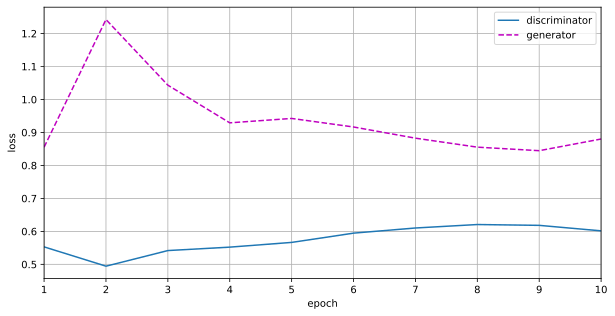

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 1e-5, 2e-4, 100, 10
trained_G = train(net_D, net_G, train_loader, num_epochs, lr_D, lr_G,
      latent_dim, None)                                                  

# TimeGAN

As mentioned in the introduction, the TimeGAN model proposed by Yoon, Jarrett and van der Schaar is designed to explictly learn stepwise conditional distributions in time series data. We now summarise the problem formulation for TimeGAN following section 3 of the TimeGAN paper; this then motivates the actual architecture of TimeGAN, which we explain further below. Note that the authors formulate TimeGAN to be able to model non-time series features as well, but we ignore this throughout the following sections as it is not relevant for our application. This results in some of the terms and equations being slightly different to those in the TimeGAN paper.

### Problem Formulation

Let $\mathcal{X}$ be a vector space of temporal features, and let $\boldsymbol{X}_{1:T} \in \mathcal{X}$ be a random vector from this space. I.e. we have that $\boldsymbol{x}_{1:T} = (\boldsymbol{x}_1, \dots, \boldsymbol{x}_T)$ is a (multivariate) time series, and it is a specific realisation of the random variable $\boldsymbol{X}_{1:T}$.

Our training set consists of $N$ of these specific realisations, so that we can denote the training set $\mathcal{D} = \{\boldsymbol{x}_{1:T}^{(n)}\}_{n=1}^{N}$. In our case, we have chosen $T=255$ as the fixed length of each training example, though in principle TimeGAN can deal with variable length sequences. Going forwards, we omit the supercript $(n)$ unless it is necessary. 

The goal is to use training data $\mathcal{D}$ to learn a joint density $\hat{p}(\boldsymbol{X}_{1:T})$ which best approximates the true density $p(\boldsymbol{X}_{1:T})$. To aid with learning $\hat{p}$, the authors additionally make use of the decomposition of the joint density
$$
    p(\boldsymbol{X}_{1:T}) = \Pi_t p(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1}) 
$$

for $t \in {1, \dots, T}$. This yields the complementary, simpler goal of using the training data to learn a density $\hat{p}(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1})$ which best approximates the true density $p(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1})$, at each time $t \in {1, \dots, T}$.

In other words, we have two objectives: first, to learn the joint distribution, and second, to learn the conditional distributions. More formally, the first objective is
$$
    \min_{\hat{p}} D (p(\boldsymbol{X}_{1:T}) \mid \mid \hat{p}(\boldsymbol{X}_{1:T}))
$$
and the second objective is 
$$
    \min_{\hat{p}} \tilde{D} (\hat{p}(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1}) \mid \mid p(\boldsymbol{X}_{t} \mid \boldsymbol{X}_{1:t-1}))
$$
for any $t \in {1, \dots, T}$. The first objective is the usual GAN objective, so $D$ denotes the Jensen-Shannon divergence. Since we can use the original data to do supervised learning of the conditional distributions, $\tilde{D}$ denotes the Kullback-Leibler divergence. The objective function of TimeGAN will be proportional to both of the objectives above, which the authors call the GAN objective and the ML objective respectively.

#### Loading data

TimeGAN is not a single neural network, but consists of five subnetworks. We explain the structure of these networks and how they interact after first defining some hyperparameters and loading the data to train the model. 

We use the same data that was used to train FinGAN; the only difference is that while FinGAN was trained on univariate sequences, TimeGAN is trained to generate a multivariate sequence.

In [ ]:
input_size = paths_scaled.shape[1]
'''
Number of variates in time series. 
E.g. for OHLC data, input_size=4
In our case, input_size=6
'''
sequence_length = 255
'''
Number of values in each variate in the (multivariate) time series. 
I.e. length of sequences we want the trained model to generate
'''
batch_size = 128
'''
A free hyperparameter.
Same batch size that was used by Yoon; it yielded good results
according to the TimeGAN paper, so we use the same.
'''

'\nA free hyperparameter.\nSame batch size that was used by Yoon; it yielded good results\naccording to the TimeGAN paper, so we use the same.\n'

In [ ]:
# X was defined above, before the FinGAN section
train_data = TensorDataset(X, torch.ones(len(X), 1))
train_loader = {
    DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)}

In [ ]:
# Shape of input (X) and output (y)
for _X_, y in train_loader:
    print(_X_.shape, y.shape)
    break

torch.Size([128, 255, 6]) torch.Size([128, 1])


### Model architecture

We now explain the model architecture of TimeGAN following section 4 of the TimeGAN paper, and then following the actual implementation of TimeGAN in TensorFlow by Yoon which can be found on GitHub. The reason for this is that there are significant differences between the TimeGAN paper and the actual implementation of TimeGAN by Yoon.

In the paper, TimeGAN consists of four subnetworks: an *embedding* network and a *recovery* network, in addition to the usual generator and discriminator networks which constitute a GAN. With TimeGAN, the entire adversarial learning process happens within a latent vector space, rather than the vector space of the original data.

#### Embedding and recovery networks
The purpose of the embedding network is to map training examples from their original vector space to a latent space, and the purpose of the recovery network is to map generated time series from the latent space back to the original vector space of the training data. Thus, the embedding and recovery networks together can be thought of as an autoencoder. 

The authors note that this latent space may be lower-dimensional than the latent space, as temporal dynamics of even complex systems are often driven by only a few underlying factors. They also note that the purpose of a (lower-dimensional) latent space is not only efficiency, in the sense that it can be modelled by a network with fewer parameters. In addition, the autoencoder is trained jointly with the other subnetworks in such a way the generator is better able to learn temporal relationships in the latent space. 

In the paper, the embedding network is implemeted via a recurrent neural network (RNN), and the recovery network is implemented via a feedforward neural network at each time step. The authors note that these two networks can be implemented by any architecture as long as they are autoregressive (meaning future values of the time series are predicted based on past values of the time series), and outputs at each time step only depend on previous information (to avoid "looking forward" in time). Indeed, in the implementation on GitHub, Yoon uses a three-layer GRU network to implement both the embedding and recovery network, which we follow in our implementation.

The autoencoder is trained to optimise the reconstruction loss 
$$
    \mathcal{L}_R = \mathbb{E}_{\boldsymbol{X}_{1:T} \sim p} \left[ \sum_t || \boldsymbol{X}_t - \boldsymbol{\tilde{X}}_t ||_2 \right]
$$
where $||\cdot||_2$ is the usual Euclidean norm and $\boldsymbol{\tilde{X}}_t$ is the reconstruction of the input $\boldsymbol{X}_t$ by the autoencoder. In practice, this loss is implemented by calculating the mean squared error between inputs and outputs of the autoencoder, where the mean is taken over all samples in a minibatch.

#### Generator and discriminator networks
The generator and discriminator networks function exactly as in traditional GANs. In the paper, the generator is implemented via a RNN, and the discriminator is implemented via a bidirectional RNN. Once again, in the implementation on GitHub, Yoon uses a three-layer GRU network to implement both the generator and discriminator networks, which we follow in our implementation.

The generator and discriminator are trained to optimise the unsupervised loss 
$$
     \mathcal{L}_U = \mathbb{E}_{\boldsymbol{X}_{1:T} \sim p} \left[ \sum_t \log y_t \right] + \mathbb{E}_{\boldsymbol{X}_{1:T} \sim \hat{p}} \left[ \sum_t \log (1 - \hat{y}_t) \right]
$$
where $y_t$ and $\hat{y}_t$ are the discriminator network's outputs when given real and synthetic data as input, respectively. This is the usual objective function for training GANs, and is implemented using the binary crossentropy loss in practice.

At this point, the authors suggest that relying solely on the discriminator's binary feedback may be insufficient to get the generator to learn the conditional distributions present in the time-series data. In order to achieve this, they wish to train the generator in two different ways:

- First, in "open-loop" mode, the generator uses its own previous outputs (due to the recurrent network structure) and an external signal $z$ (which is in fact just a noise vector, i.e. the usual input for a generator in a GAN) in order to generate a synthetic time series $\hat{h}_{1:T}$. This synthetic time series is then given as input to the discriminator along with a real time series, so that the unsupervised loss can be computed (this is if the batch size is 1. In practice, multiple real series and multiple synthetic series are given as input to the discriminator in order to compute the unsupervised loss for a minibatch). Then we backpropagate gradients through the network, and update to minimise the the unsupervised loss.
- Second, in "closed-loop" mode, the generator receives sequences of embeddings of *real* time series $h_{1:T}$ (an embedding of a real time series is what we get after it has been passed through the embedding network), which are, presumably, supposed to be used **inplace of the generator's own previous outputs** when generating another synthetic time series $\hat{h}_{1:T}$ (we still have a noise vector as the external signal in the RNN). This requires a non-standard implementation of an RNN, since usually, the RNNs own output at the previous time step (or, sometimes, the hidden state vector at the previous time step) is used to compute the output at the next time step. This issue leads us to the supervisor network. 

#### Supervisor network
The major difference between the paper and the GitHub implementation is the addition of a fifth network, called the *supervisor*, to the structure of TimeGAN. The supervisor network achieves the goal of training the generator in "closed-loop" mode. Before describing the supervisor network, the purpose of training in closed-loop mode, according to the authors, is that it allows the generator to learn conditional distributions in the time-series data through the optimisation of the supervised loss 
$$
    \mathcal{S}_U = \mathbb{E}_{\boldsymbol{X}_{1:T} \sim p} \left[ \sum_t || \boldsymbol{h}_t - g_{\mathcal{X}}(\boldsymbol{h}_{t-1}, \boldsymbol{z}_t) ||_2 \right].
$$
Here, $g_{\mathcal{X}}$ is the generator and it is implemented by a recurrent neural network. As mentioned above, $g_{\mathcal{X}}(\boldsymbol{h}_{t-1}, \boldsymbol{z}_t)$ is the output of the generator at time $t$, when embeddings of some real time series are used inplace of the generator's own previous outputs at each time step. This loss allows the generator to learn the distributions $\hat{p}(h_{t} \mid \boldsymbol{h}_{1:t-1})$, $t \in {1, \dots, T}$, which are the stepwise conditional distributions of the embeddings of the real time series. The loss above is called "supervised", since closed-loop training is supervised learning: we can compare the generator's output at each time to the actual value of embedding of the real time series at that time.

Now, presumably due to the issue mentioned above, in the implementation on GitHub, Yoon uses a *separate* network called the supervisor to perform this closed-loop training step. Thus, what we have called the 'supervisor' and 'generator' networks so far, when put together, correspond to what the authors call the 'generator' network in their paper. Indeed, see [Yoon's reply to someone's question about this on GitHub](https://github.com/jsyoon0823/TimeGAN/issues/25). Going forwards, we may use the terms "subgenerator" and "supergenerator", where the former refers to the network which performs open-loop training and is used to compute the unsupervised loss, and the latter refers to the combination of the subgenerator and supervisor networks, which together perform both open and closed loop training, and correspond to what is called the "generator" in the TimeGAN paper. To clarify what we mean by a "combination" of the subgenerator and supervisor, since neural networks are just functions, we think of the supergenerator as a function which is a *composition* of the subgenerator and supervisor.

We can see that the supervised loss is designed to achieve the second training objective in the problem formulation (the objective with the KL-divergence), and that the unsupervised loss is designed to achieve the first trainign objective in the problem formulation (the objective with the JS divergence). The reconstruction loss only indirectly helps achieve these objectives, but allowing the autoencoder to learn a latent space in which the other networks can train effectively. 

We now present the implementation of TimeGAN. We used Yoon's implementation, in addition to two other implementations on GitHub, as a reference to guide this process. Links to these sources can be found in the section on references below. 

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()

        '''
        Initialise weights; this is copied verbatim from
        https://github.com/d9n13lt4n/timegan-pytorch and is supposed 
        to mimic the weight initialisation used in the tensorflow implementation.
        Full credit to the author.
        '''
        with torch.no_grad():
            for name, param in self.GRU.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, X):
        '''
        Args:
            X: minibatch of input timeseries 
            (batch_size, sequence_length, input_size)
        Returns:
            o: minibatch of timeseries 
            (batch_size, sequence_length, hidden_size)
        '''
        o, h = self.GRU(X)
        o = self.linear(o)
        o = self.sigmoid(o)
        return o

In [ ]:
class Discriminator(nn.Module):
    '''
        For some reason, 
        implementations do not use sigmoid activation for the discriminator,
        and they use BCEWithLogitsLoss instead of BCELoss. 
        Why? For numerical stability: see the first paragraph of 
      https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html.
    '''
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

        '''
        Initialise weights; this is copied verbatim from
        https://github.com/d9n13lt4n/timegan-pytorch and is supposed 
      to mimic the weight initialisation used in the tensorflow implementation.
        Full credit to the author.
        '''
        with torch.no_grad():
            for name, param in self.GRU.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)
    
    def forward(self, X):
        '''
        Args:
      X: minibatch of input timeseries (batch_size, sequence_length, input_size)
        Returns:
      o: minibatch of timeseries (batch_size, sequence_length, hidden_size)
        '''
        o, h = self.GRU(X)
        o = self.linear(o)
        return o

In [ ]:
# Define other params
z_size = 24
'''
Number of variates in noise vector, a hyperparameter.
In the original implementation, they let z_size=input_size
However, we found that this value of z_size works well
'''

latent_size = 24
''' 
I.e. hidden_size.
A hyperparemeter, it is the 'size' of the latent space. 
The latent space is meant to be 'smaller' in dimension, so 
latent_size should be less or equal to input_size, right?
Not necessarily. Sometimes having latent_size bigger than 
input_size is helpful: see 
https://github.com/jsyoon0823/TimeGAN/issues/23
'''

num_layers = 1
'''
A hyperparameter, can be different for each network
Original implementations use num_layers=3 for all
But since we have much longer sequence length, we set it
equal to 1, so that we don't have a huge number of 
parameters in our network
'''

"\nA hyperparameter, can be different for each network\nOriginal implementations use num_layers=3 for all\nBut since we have much longer sequence length, we set it\nequal to 1, so that we don't have a huge number of \nparameters in our network\n"

In [ ]:
# Instantiate networks
embedding = RNN(input_size, latent_size, num_layers)
recovery = RNN(latent_size, input_size, num_layers)

subgenerator = RNN(z_size, latent_size, num_layers) 
# I believe that second argument is a pure hyperparameter
discriminator = Discriminator(latent_size, latent_size, num_layers) 

# Yoon uses num_layers-1 instead of num_layers. But we set num_layers=1
supervisor = RNN(latent_size, latent_size, num_layers) 

In [ ]:
# Define optimisers
lr = 1e-3

discriminator_optimiser = torch.optim.Adam(discriminator.parameters(), lr=lr)
supervisor_optimiser = torch.optim.Adam(supervisor.parameters(), lr=lr)
embedding_optimiser = torch.optim.Adam(embedding.parameters(), lr=lr)
recovery_optimiser = torch.optim.Adam(recovery.parameters(), lr=lr)
subgenerator_optimiser = torch.optim.Adam(subgenerator.parameters(), lr=lr)

## Training

Let $\theta_e, \theta_r, \theta_g, \theta_d$ and $\theta_s$ denote the parameters of the embedding, recovery, subgenerator, discriminator and supervisor networks respectively. In the TimeGAN paper, the authors seek to train the subnetworks with the objective 
$$
    \min_{\theta_e, \theta_r} (\lambda \mathcal{L}_S + \mathcal{L}_R),
$$
and the objective 
$$
    \min_{\theta_g} (\eta \mathcal{L}_S + \max_{\theta_d} \mathcal{L}_U),
$$
where $\lambda$ and $\eta$ are hyperparameters which balance the losses.

The first objective includes the supervised loss, because the aim is for the autoencoder to learn a latent space which is especially suited for allowing the generator to learn stepwise conditional distributions in the data, rather than to just reduce the dimensionality of the data. 

In practice, in Yoon's implementation and in our implementation below, because of the supervisor network, the second objective can be imagined to be split into the objective
$$
    \min_{\theta_g} (\max_{\theta_d} \mathcal{L}_U),
$$
which is the usual minimax formulation of the GAN training objective, and
$$
    \min_{\theta_s} (\mathcal{L}_S).
$$
This makes sense, because we think of the generator in the original paper as corresponding to the subgenerator and supervisor networks in this report.

We follow the training process in Yoon's implementation on GitHub, which consists of three steps. First, the autoencoder (embedding and recovery networks) are trained to minimise the reconstruction loss (MSE between inputs and outputs of autoencoder). Second, the supervisor network is trained. Finally, all five subnetworks are trained simultaneously, as described above. Hence, the first two steps can be thought of as "pre-training" for the actual TimeGAN training phase, which comes last. 

In [ ]:
def reset_gradients():
    '''
    Helper function to reset gradients of TimeGAN
    i.e. to reset gradients of all subnetworks of 
    TimeGAN
    '''
    embedding.zero_grad()
    recovery.zero_grad()
    subgenerator.zero_grad()
    supervisor.zero_grad()
    discriminator.zero_grad()

### Step 1: Train Autoencoder

In [ ]:
def train_autoencoder(train_loader, num_epochs):
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            legend=['autoencoder'])

    for epoch in range(1, num_epochs+1):

        for X, _ in train_loader:
            reset_gradients()

            # Forward pass
            H = embedding(X.float())
            X_tilde = recovery(H)

            # Calculate encoder loss
            E_loss_T0 = F.mse_loss(X, X_tilde)
            E_loss0 = 10 * torch.sqrt(E_loss_T0)
            '''
            Not 100% sure why this transformation is applied
            But we defer to the judgement of the TimeGAN authors
            '''

            E_loss0.backward()
            embedding_optimiser.step()
            recovery_optimiser.step()

        animator.add(epoch, (E_loss_T0, 0))

### Step 2: Train supervisor

In [ ]:
def train_supervisor(train_loader, num_epochs):

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            legend=['supervisor'])
    
    for epoch in range(1, num_epochs+1):

        for X, _ in train_loader:
            reset_gradients()

            # Forward pass
            H = embedding(X.float())
            H_hat_supervise = supervisor(H)

            # Calculate supervisor loss
            G_loss_S = F.mse_loss(H[:, 1:, :], H_hat_supervise[:, :-1, :])
            '''
    Seeks to minimise the L_2 distance between the first sequence_length-1 
    values of the original series, and the last sequence_length-1 values
    of the supervised original series, and this all takes place the latent space.
            
        I.e. the supervisor tries to learn the conditional distribution 
        P(x_t | x_{t-1}, x_{t-2}, ..., x_1)
            '''

            G_loss_S.backward()
            supervisor_optimiser.step()
        
        animator.add(epoch, (G_loss_S, 0))

### Step 3: Joint training

In [ ]:
def trainstep_generator(X, gamma=1):
    # Generate noise vector
    Z = torch.rand(X.shape[0], sequence_length, z_size)

    reset_gradients()

    # Forward pass
    H = embedding(X.float())
    H_hat_supervise = supervisor(H)

    E_hat = subgenerator(Z)
    H_hat = supervisor(E_hat) 

    X_hat = recovery(H_hat)

    Y_fake = discriminator(H_hat)
    Y_fake_e = discriminator(E_hat) 

    # Calculate (super)generator loss
    G_loss_U = {
        F.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))}
    G_loss_U_e = {
        F.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e))}

    G_loss_S = F.mse_loss(H[:, 1:, :], H_hat_supervise[:, :-1, :])

    G_loss_V1 = torch.mean(torch.abs(
        torch.sqrt(X_hat.var(dim=0, unbiased=False) + 1e-6) {
            - torch.sqrt(X.var(dim=0, unbiased=False) + 1e-6)}
        ))
    G_loss_V2 = torch.mean(torch.abs(
        X_hat.mean(dim=0) - X.mean(dim=0) 
        ))
    G_loss_V = G_loss_V1 + G_loss_V2
    '''
    This is called a 'moment-matching' loss, 
    and is designed to keep the mean and variance of 
    generated samples similar to that of real samples. 
    It is helpful for tackling 'mode collapse'
    issue when training GANs; 
    this is when the GAN ends up generating exactly the same sample each
    time, even if the noise vector is different.
    '''

    G_loss = G_loss_U + gamma * G_loss_U_e + 100 * torch.sqrt(G_loss_S) {
        + 100 * G_loss_V}

    G_loss.backward()
    subgenerator_optimiser.step()
    supervisor_optimiser.step()

    return G_loss

In [ ]:
def trainstep_autoencoder_joint(X):
    reset_gradients()

    # Forward pass
    H = embedding(X.float())
    X_tilde = recovery(H)

    H_hat_supervise = supervisor(H)

    G_loss_S = F.mse_loss(H[:, 1:, :], H_hat_supervise[:, :-1, :])

    # calculate embedder loss
    E_loss_T0 = F.mse_loss(X, X_tilde)
    E_loss0 = 10 * torch.sqrt(E_loss_T0)

    # Not entirely sure why 0.1*G_loss_S is added,
    # Because the supervisor is not updated here
    E_loss = E_loss0 + 0.1 * G_loss_S 
    E_loss.backward()

    embedding_optimiser.step()
    recovery_optimiser.step()

    return E_loss

In [ ]:
def trainstep_discriminator(X, gamma=1):
    # Generate noise vector
    Z = torch.rand(X.shape[0], sequence_length, z_size)

    reset_gradients()

    # Forward pass
    H = embedding(X.float()).detach()
    E_hat = subgenerator(Z).detach()
    H_hat = supervisor(E_hat).detach()
    '''
    We use detach, as there's no need to compute gradients
    for the autoencoder and the generator in this function
    '''

    Y_real = discriminator(H)
    Y_fake = discriminator(H_hat)
    Y_fake_e = discriminator(E_hat) 

    # Calculate discriminator loss
    D_loss_real = {
        F.binary_cross_entropy_with_logits(Y_real, torch.ones_like(Y_real))}
    D_loss_fake = {
        F.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))}
    D_loss_fake_e = {
        F.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e))} 

    unsupervised_loss = D_loss_real + D_loss_fake
    D_loss = unsupervised_loss + gamma * D_loss_fake_e

    if D_loss > 0.15:
        '''
        Train discriminator only when it is not working well
        '''
        D_loss.backward()
        discriminator_optimiser.step()

    return D_loss

In [ ]:
def train_joint(train_loader, num_epochs):

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                        xlim=[1, num_epochs], nrows=1, 
                        legend=['generator', 'autoencoder', 'discriminator'])
    
    D_losses = []
    for epoch in range(1, num_epochs+1):
        for X, y in train_loader:
            
            for _ in range(2):
                '''
                Train discriminator half as often as 
                the generator and autoencoder
                '''
                G_loss = trainstep_generator(X)
                E_loss = trainstep_autoencoder_joint(X)
            
            D_loss = trainstep_discriminator(X)

        D_losses.append(D_loss)
        animator.add(epoch, (G_loss, E_loss, D_loss))
    
    return D_losses

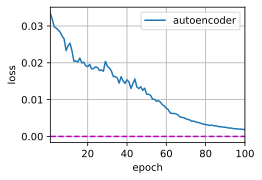

In [ ]:
train_autoencoder(train_loader, 100)

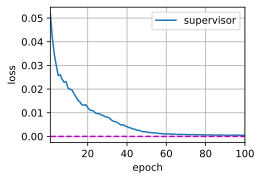

In [ ]:
train_supervisor(train_loader, 100)

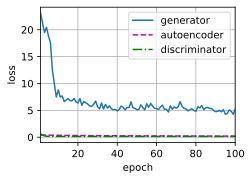

In [ ]:
D_losses = train_joint(train_loader, 100)

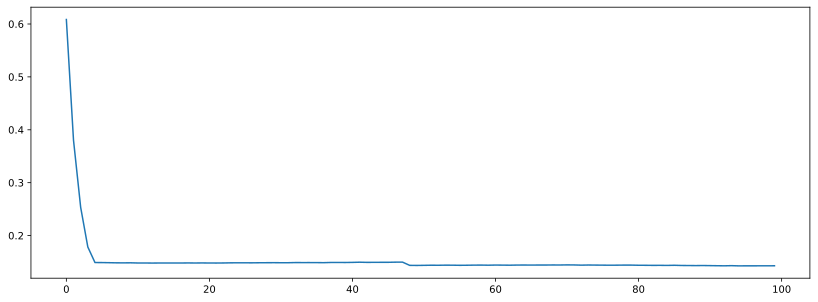

In [ ]:
# Discriminator losses, zoomed in
plt.plot(D_losses)

### Comments on training

We can see that the generator improves very slowly, if at all, in the last 70 epochs of training. At the same time, we see that the discriminator stops being updated extremely early in the training process. Therefore, we guess that we may see an improvement in the generator if we slow down the discriminator training further, based on the idea that we want the generator and discriminator to improve at the same 'rate', rather than the discriminator learning very quickly as it does here. We leave this experiment for a future work. 

### Save/load model parameters

In [ ]:
# Save model parameters

suffix = "__placeholder__"

torch.save(embedding.state_dict(), f"trained_TimeGAN/embedding{suffix}")
torch.save(recovery.state_dict(), f"trained_TimeGAN/recovery{suffix}")
torch.save(subgenerator.state_dict(), f"trained_TimeGAN/subgenerator{suffix}")
torch.save(supervisor.state_dict(), f"trained_TimeGAN/supervisor{suffix}")
torch.save(discriminator.state_dict(), f"trained_TimeGAN/discriminator{suffix}")

In [ ]:
# Load model parameters

'''
Trained model suffixes:
"_50e_no_init": lots of periodicity, short periods in stacked version.
 Lots of noise in sequential
"_50e_with_init": longer periods. Lots of noise in sequential 
"_50e_with_init_zs6": z_size=6. For all the other models we use z_size=24, 
it seems to work better
"_500e_with_init_zs24": No better than _50e_with_init! 
In fact, generated samples are EXACTLY the same.
"_100e_with_init_zs24_nl1_sl255": 
Trained on S&P data. num_layers=1, sequence_length=255
'''

suffix = "_100e_with_init_zs24_nl1_sl255"

embedding.load_state_dict(torch.load(f"trained_TimeGAN/embedding{suffix}"))
recovery.load_state_dict(torch.load(f"trained_TimeGAN/recovery{suffix}"))
subgenerator.load_state_dict(torch.load{
    (f"trained_TimeGAN/subgenerator{suffix}"))}
supervisor.load_state_dict(torch.load(f"trained_TimeGAN/supervisor{suffix}"))
discriminator.load_state_dict(torch.load{
    (f"trained_TimeGAN/discriminator{suffix}"))}

<All keys matched successfully>

# Evaluation

After performing a manual visual inspection, we use a combination of the evaluation methods in the FinGAN paper and the TimeGAN paper, in addition to a third quantitative measure:

1. Check whether volatility clustering and heavy tails can be observed in the generated time series
2. Use tSNE to visualise the joint distributions of the real and generated time series in 2D, and inspect how similar they are.
3. Use Jenson-Shannon Divergence as a quantitative evaluation technique to measure the similarity between 2 probability distributions (Real vs Generated)

We could also use the following evaluation methods, which were used in the TimeGAN paper:

- Train an RNN time series classifier (or use a pre-trained one, maybe using transfer learning) to distinguish between the original and synthetic time series. If the synthetic ones are perfectly realistic, we would expect that this RNN classifier gets an accuracy of around 50% on a held-out test set. Essentially, the closer this classifier's accuracy is to 50%, the better. 
- Perform a variation of the Train Synthetic Test Real procedure, to see whether TimeGAN captures the conditional distributions in the training data. 

However, both of these methods involve training new RNNs, so we leave this for a future work. 

### FinGAN visual inspection
We will now see see what the time series generated by FinGAN looks like. To do this, we obtain the generated time series by passing the standard normal noise vector $Z$ into the trained Generator and select 6 samples. 

In [ ]:
n_series_to_generate = 6
Z = torch.normal(0, 1, size=(n_series_to_generate, 100))
generated_series = trained_G(Z)

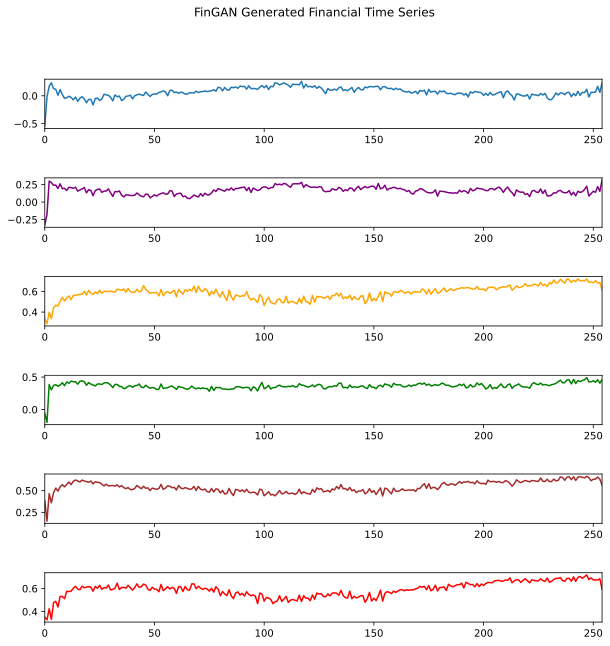

In [ ]:
# Individual subplots
fig, ax = plt.subplots(6, figsize=(10, 10))
fig.subplots_adjust(hspace=1)
fig.suptitle('FinGAN Generated Time Series')

ax[0].plot(generated_series[-1].detach().numpy().T)
ax[0].set_xlim([0, 254])

ax[1].plot(generated_series[-2].detach().numpy().T, color='purple')
ax[1].set_xlim([0, 254])

ax[2].plot(generated_series[-3].detach().numpy().T, color='orange')
ax[2].set_xlim([0, 254])

ax[3].plot(generated_series[-4].detach().numpy().T, color='green')
ax[3].set_xlim([0, 254])

ax[4].plot(generated_series[-5].detach().numpy().T, color='brown')
ax[4].set_xlim([0, 254])

ax[5].plot(generated_series[-6].detach().numpy().T, color='red')
ax[5].set_xlim([0, 254]);

### TimeGAN visual inspection
We also obtain the TimeGAN's generated time series by passing a random tensor to the generator function, i.e. we perform a forward pass through the supergenerator. 

The generated series does not look entirely unlike a financial time series. However, from the randomly selected window we have shown, there seems to be a higher correlation between each variate in the generated time series, compared to the correlations in the real time series. 

In [ ]:
# Define helper functions
def generate(Z):
    '''
    Generates synthetic time series of length sequence_length
    when given a noise vector of shape (1, sequence_length, z_size)
    '''
    E_hat = subgenerator(Z)
    H_hat = supervisor(E_hat)
    X_hat = recovery(H_hat)
    return X_hat

def stack(X):
    '''
    (Helper function)
    Since TimeGAN was trained on a multivariate series,
    we stack the data so it is as if we had univariate 
    series 
    '''
    X_stacked = []
    for multivariate_window in X:
        for variate in range(input_size):
            X_stacked.append(multivariate_window.T[variate])

    X_stacked = np.array(np.vstack(X_stacked))

    return X_stacked

In [ ]:
generated_X = generate(torch.randn(X.shape[0], sequence_length, z_size)).detach().numpy()

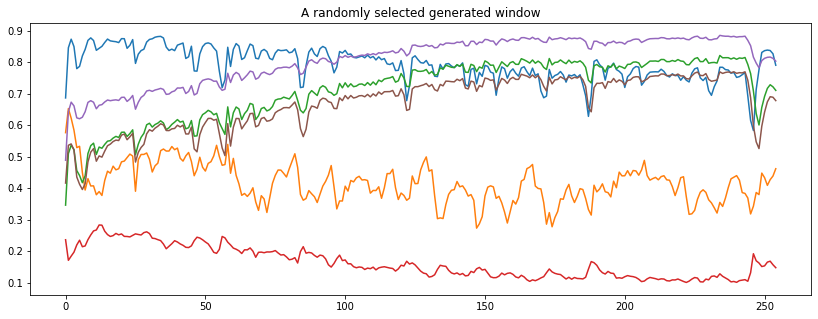

In [ ]:
# Plot a randomly selected generated window
plt.title("A randomly selected generated window")
plt.plot(np.array(generated_X)[random.sample(list(np.arange(generated_X.shape[0])), 1)[0]]);

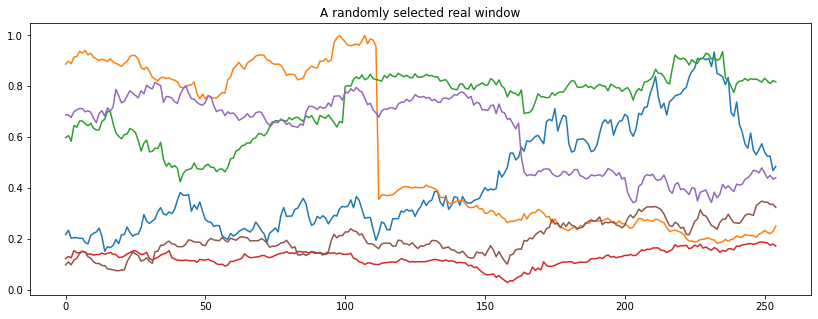

In [ ]:
# Plot a randomly selected real window
plt.title("A randomly selected real window")
plt.plot(np.array(X)[random.sample(list(np.arange(X.shape[0])), 1)[0]]);

### Checking financial time series characteristics
#### Volatility Clustering
Once we have the generated data, we can compare volatility cluster characteristics of the realised vs generated time series for FinGAN & TimeGAN by creating a time series subplot:

Observing the TimeGAN plot, we note that the generated time series does display volatility clusters, with a series of large fluctuations followed by low fluctuations. However, the amplitude of the fluctuations are much larger compared to the real time series data, which is puzzling. Therefore, we can conclude that the TimeGAN does vaguely generate a time series that exhibits volatility clusters.

Observing the FinGAN plot, we note that the generated time series does not display volatility clusters, and instead appears to follow an alternating drift trajectory. Hence, we can conclude that the MLP Generator's synthetic data does not exhibit the empirically observed volatility clustering characteristic of financial time series.

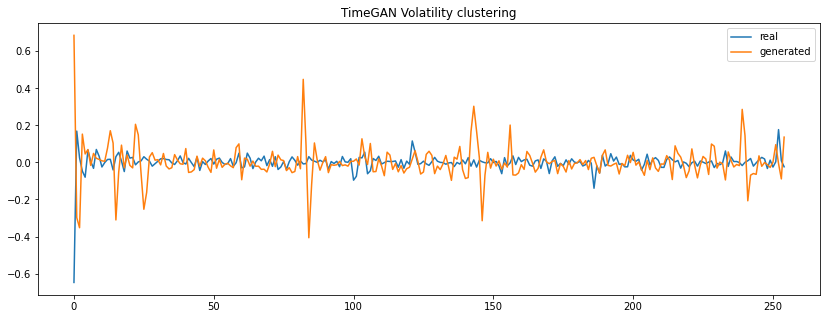

In [ ]:
# TimeGAN:
# Randomly select windows to visualise
real_window = stack(X)[random.sample(list(np.arange(stack(X).shape[0])), 1)].T
generated_window = stack(generated_X){
    [random.sample(list(np.arange(stack(generated_X).shape[0])), 1)].T}

# Calculate log returns
real_rets = np.log(real_window) - np.log(np.roll(real_window, 1))
generated_rets = np.log(generated_window) - np.log(np.roll(generated_window, 1))

plt.title("TimeGAN Volatility clustering")
plt.plot(real_rets, label="real")
plt.plot(generated_rets, label="generated")
plt.legend();

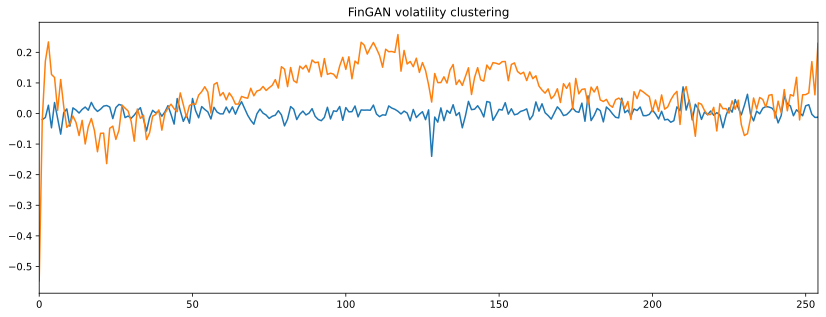

In [ ]:
# FinGAN:
plt.title('FinGAN volatility clustering')
plt.plot(df_AAL["log_r"], label='real') # Realised AAL time series
# FinGAN generated time series
plt.plot(generated_series[-1].detach().numpy().T, label='generated') 
plt.xlim([0,254]);

#### Heavy Tails
We now compare the heavy tailed characteristics of the realised vs generated time series for FinGAN & TimeGAN by creating a QQplot subplot:

Observing the TimeGAN plot, we note that both plots do not exhibit heavy tails, with many observations deviating from implied by a normal pdf. However, the generated data has more extreme observations compared to the real which is puzzling. Therefore, we can conclude that the TimeGAN does not generate a time series that exhibits heavy tails, and instead follows a different distribution.

Observing the FinGAN plot, we note that the generated time series does not have as much tail deviation compared to the AAL QQplot. As well as this, we can see that the generated time series is very close to what would be expected if the data was normally distributed (red line). Hence, we can conclude that the MLP Generator's synthetic data does not exhibit the empirically observed heavy tailed characteristic of financial time series

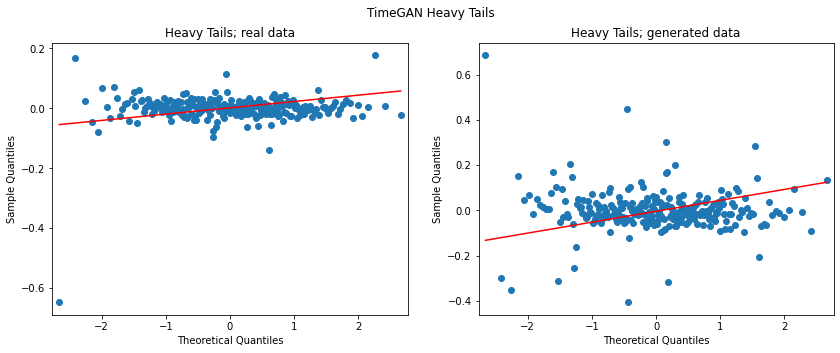

In [ ]:
# TimeGAN:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('TimeGAN Heavy Tails')
ax[0].set_title("Heavy Tails; real data")
sm.qqplot(real_rets, line='q', ax=ax[0])
ax[1].set_title("Heavy Tails; generated data")
sm.qqplot(generated_rets, line='q', ax=ax[1]) 
plt.show()

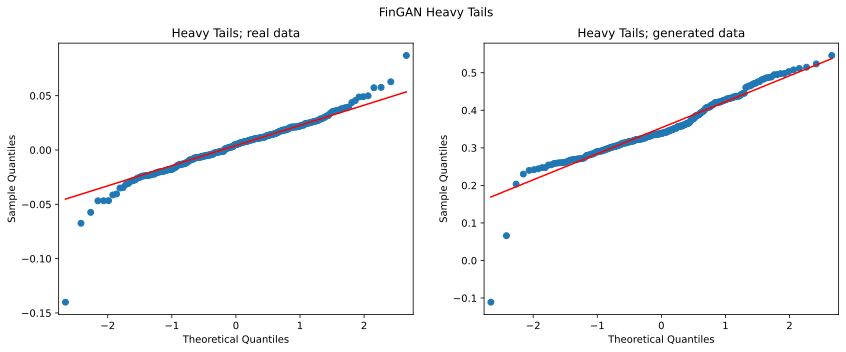

In [ ]:
# FinGAN:
real_data = df_AAL["log_r"]
real_data = real_data[0:255]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('FinGAN Heavy Tails')
ax[0].set_title("Heavy Tails; real data")
sm.qqplot(real_data, line='q', ax=ax[0])
ax[1].set_title("Heavy Tails; generated data")
sm.qqplot(generated_series[-1].detach().numpy().T, line='q', ax=ax[1]) 
plt.show()

### tSNE visualisation

tSNE is an algorithm which allows us to visualise high-dimensional vectors in 2D space. It is designed in such a way that two vectors that are close together in high-dimensional space will also be close together in the lower-dimensional 2D space, and vice versa. Thus, if the distributions of the real and generated data appear similar in the 2D plot, we can infer that the distributions of real and generated data are similar in their original high-dimensional space. 

We observe that in 2D, the distributions of real data and data generated by TimeGAN are quite dissimilar, with clusters of generated data and non-linear lines for real data. For FinGAN, we observe that the distributions are quite similar in the sense that they are both non-linear lines, however the FinGAN data has to be re-shaped to be used in the function, so we cannot determine if the results are realistic.

In [ ]:
def visualise_tSNE(real, generated):
    #Learning rate is typically between 10 and 1000
    tSNE_real = TSNE(learning_rate = 50, init='random')
    tSNE_generated = TSNE(learning_rate = 50,  init='random') 

    tsne_features_real = tSNE_real.fit_transform(real)
    tsne_features_generated = tSNE_generated.fit_transform(generated)

    df_tsne_features_real = pd.DataFrame()
    df_tsne_features_real['x'] = tsne_features_real[:, 0]
    df_tsne_features_real['y'] = tsne_features_real[:, 1]
    df_tsne_features_real['type'] = ["real"] * len(tsne_features_real[:, 0])

    df_tsne_features_generated = pd.DataFrame()
    df_tsne_features_generated['x'] = tsne_features_generated[:, 0]
    df_tsne_features_generated['y'] = tsne_features_generated[:, 1]
    df_tsne_features_generated['type'] = {
        ["generated"] * len(tsne_features_generated[:, 0])}

    df_tsne_features = pd.concat([df_tsne_features_real, {
        df_tsne_features_generated], axis=0, sort=False)}

    sns.scatterplot(x = "x", y = "y", hue="type", data = df_tsne_features)

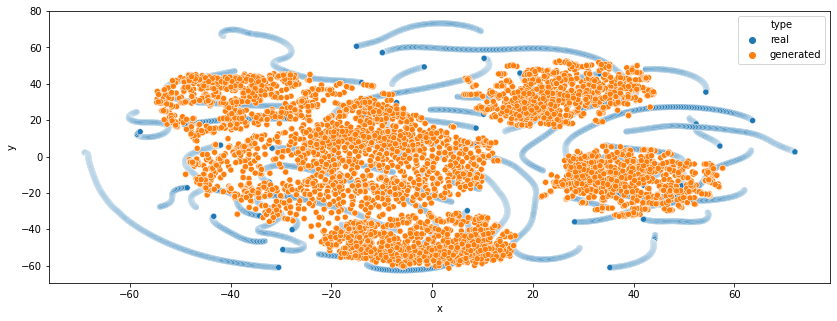

In [ ]:
# TimeGAN tSNE:
visualise_tSNE(stack(X), stack(generated_X))

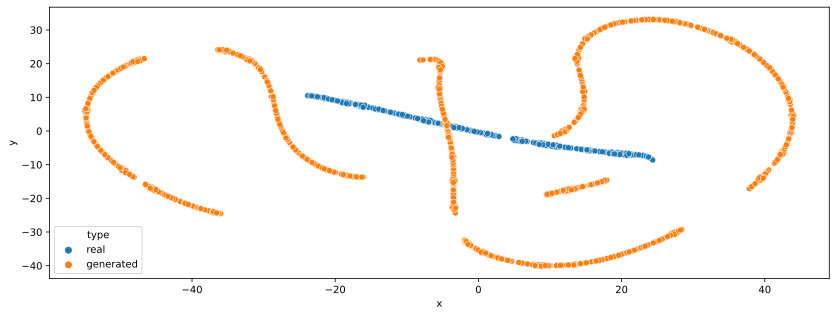

In [ ]:
# FinGAN tSNE:
gen_data_fin = generated_series.detach()
real_data_fin = np.array(real_data)
real_data_fin = torch.tensor(real_data_fin)

real_data_fin = real_data_fin.reshape(-1,1)
gen_data_fin = gen_data_fin.reshape(-1,1)

visualise_tSNE(real_data_fin, gen_data_fin)

### JS Divergence
JS Divergence is a method of measuring the similarity between 2 probability distributions, where the optimal Generator minimises the JS Divergence between the real and generated distributions. Hence, we will be using the JS Divergence as an evaluatory metric to assess the similarity of the real and generated distributions for the TimeGAN and FinGAN.

First, we provide an expression for JS Divergence and its useful properties compared to KL Divergence:

$D_{JS}\left(p_{d}||d_{g}\right) = \frac{1}{2}D_{KL}\left(p_{d}||\frac{\left(p_{d}+p{g}\right)}{2}\right) + \frac{1}{2}D_{KL}\left(p_{g}||\frac{\left(p_{d}+p{g}\right)}{2}\right)$ 
(which $=0 \leftrightarrow$$p_{g} = p_{d}$)

Where:

- $p_{d}$ ~ data distribution
- $p_{g}$ ~ generated distribution

Properties:

- Symmetrical: Same value for any pair combination $\{p_{d}, p_{g}\}$
- Bounded between 0 and log2: value does not $\rightarrow\infty$ for very different distributions

We now define the JS-Divergence function, [which we found from jeff-hykin's post on the PyTorch forum.](https://discuss.pytorch.org/t/jensen-shannon-divergence/2626)

In [ ]:
def JSD(net_1_logits, net_2_logits):
    from torch.functional import F
    net_1_probs = F.softmax(net_1_logits, dim=0)
    net_2_probs = F.softmax(net_2_logits, dim=0)
    
    total_m = 0.5 * (net_1_probs + net_1_probs)
    
    loss = 0.0
    loss += F.kl_div(F.log_softmax(net_1_logits, dim=0), {
        total_m, reduction="batchmean") }
    loss += F.kl_div(F.log_softmax(net_2_logits, dim=0), {
        total_m, reduction="batchmean") }
    return (0.5 * loss)

In [ ]:
# JSD calculations:
gen_data_fin_JSD = generated_series[-1].detach()
real_data_fin_JSD = np.array(real_data)
real_data_fin_JSD = torch.tensor(real_data_fin_JSD)

JSD_FinGAN = JSD(real_data_fin_JSD, gen_data_fin_JSD).numpy()
JSD_FinGAN

array(5.51992534e-06)

In [ ]:
# TimeGAN data:
gen_data_time = torch.tensor(generated_X)
real_data_time = torch.tensor(X)

# JSD calculations:
JSD_TimeGAN = JSD(real_data_time, gen_data_time).numpy()
JSD_TimeGAN

/Users/Sanjit/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


array(0.0210817, dtype=float32)

Comparing the JS Divergence for both models, we observe that the FinGAN has a much lower value (closer to 0) compared to the TimeGAN, which implies that the data distribution $p_{d}$ is closer to the generated distribution $p_{g}$ for the FinGAN. Therefore, we can conclude that the FinGAN's MLP Generator has performed better at generating a distribution that is closer to the realized distribution.

However, it is useful to note that a possible reason for this is likely due to both model using the same realised financial time serires data as an input into the Discriminator. Hence, the FinGAN has a lower JS Divergence due to being designed to generate financial time series characteristics, whereas TimeGAN is built for generating standard time series data.

# Conclusion
## FinGAN
Our findings above provide evidence that our FinGAN model (MLP Generator; MLP-CNN Discriminator) does not generate a synthetic financial time series that exhibits empirically known characteristics. However, the MLP Generator in the original FinGAN paper was able to produce the 6 major stylized facts mentioned in the opening of this project, which is puzzling. Therefore, we now outline some reasons / solutions that can be utilised to produce similar results:


#### Large fluctuations in time series
The MLP Generator in the FinGAN paper produced a time series with relatively large fluctuations, which is similar to our findings shown above. Hence, as our synthetic time series was fairly unsimilar to the realised log returns for AAL, this may imply that the synthetic time series from the paper was also unsimilar to the realised S&P 500 data. Therefore, we will omit the large fluctuations in our synthetic time series as a possible reason for not displaying the observed characteristics.


#### Batch normalisation
The paper also mentions that the employment of batch normalisation in the MLP Generator led to an unrealistic time series, due to the time series exhibiting strong autocorrelation. This can be explained by the purpose of batch normalisation, which is to rescale the hidden vectors in the Generator by keeping the mean and variance consistent during training. However, financial time series are modelled to follow an Ito Process (stochastic) and thus the mean and variance is constantly changing, which implies that financial time series autocorrelation is insignificant. Therefore, a possible solution is to remove the batch normalisation from the MLP Generator, or use an entirely different architecture altogether. 


#### Hyperparameters
It is well known that GANs are inherently unstable and very sensitive to hyperparameters, due to being composed of 2 competing networks with seperate loss functions. Therefore, there is some ambiguity between selecting new hyperparameters as opposed to using the current selection (used in FinGAN paper), as different learning rates and initial ADAM $\beta_{1}$'s are likely to lead to more instability. Also, the hyperparameters that we used can be interpreted as the "industry standard", with 1e-5 and 2e-4 learning rates being very common across other GANs, which can further be used as a reason to omit changing the hyperparameters to generate a more realistic time series. 

However, it is useful to note that increasing the number of epochs to a much higher value (e.g 5000) would likely lead to convergence of the Generator and Discrimintor loss. This could be achieved by running the code on Google Collab with the GPU (cuda), but it would still be ambigious to whether or not the generated data exhibited the financial time series characteristics.


#### Comparison with other models
We mentioned in the opening of this project that GANs allow us to construct models that can learn the behaviours of various systems without a full understanding of the underlying mechanisms, and thus we want to test if our proposed solution can generate a realistic financial time series. Hence, our future direction is to see if changing the model architecture will work in practice, where we suggest the following models: W-GAN, DC-GAN

## TimeGAN
The results for TimeGAN are not as good as we expected, given the results obtained by the authors of the TimeGAN paper (in particular, their tSNE plots showed much more overlap between real and generated distributions). While TimeGAN seems to be able to reproduce volatility clusters, and does not perform poorly on a visual inspection test, it is nowhere close to reproducing heavy tails and has a much higher JS divergence than even FinGAN. We suggest two main explanations for this. 

Firstly, our model generates sequences which are around ten times longer than the sequences generated by the authors of TimeGAN (assuming that the results in the paper were obtained using Yoon's implementation on GitHub), so the learning task is much more difficult. This is a limitation of choosing to use TimeGAN to generate financial time series, and compare to FinGAN, since the generated series need to be long enough to observe characteristics like volatility clustering and heavy tails. 

Secondly, we believe the learning process could be improved by tuning hyperparameters like the learning rate, the threshold at which the discriminator stops being updated (it is set to 0.15 in this implementation), how often the discriminator is updated, and others. This is left for a future work; we were not able to complete this process due to time constraints. 

Below, we comment on some other aspects of our TimeGAN implementation which could be improved in a future work. 

#### Data
Right now, the entire dataset is scaled using a single scaler. If we really want price series to be homogeneous, we could scale each extracted window individually. We could also experiment with including more variates in the time series (i.e. asking TimeGAN to model more asset prices), or including fewer variates in the time series. 

#### Evalutation
Evaluate TimeGAN in a more quantitative way, starting with the two methods from the TimeGAN paper which we mentioned above. This will remedy another shortcoming of our current evaluation techniques, which is that we do not check whether either model was able to learn conditional distributions in the time series data.

#### A variation of TimeGAN 
We believe it is interesting to implement a version of TimeGAN with the following changes, noting that it may or may not be theoretically well-founded:

- The subgenerator generates a long time series when given noise as input.
- The supervisor structure is as it is now. But instead of processing a single 255-length window for every output of the subgenerator (which right now is a 255-length sequence), it processes all possible windows of length 255 in the long time series (i.e. len(long_time_series) - 255 of them). Then, we ask the supervisor optimiser to minimise the sum, mean, or some other function of all of these individual losses. 

We believe this structure allows the model to generate long time series, but with a slightly smaller increase in the number of parameters to be estimated compared to the situation where we just increased the parameter sequence_length on the current version of TimeGAN.

Another possible variation, with the same goal of generating longer time series, is the following:

- Make use of TimeGAN's ability to model static features (in addition to the time series features). The static feature we would give is a time variable T, which denotes where the 255-length sequence belongs in the context of some much longer time series. In other words, we would be able to give two parameters to the supergenerator: not only the noise vector, but also a time variable T, which encodes where the 255-length sequence belongs in the context of the long time series. E.g. T=0 means the 255-length window is supposed to represent the first 255 values of the long time series. 
- All other aspects of TimeGAN structure are unchanged. Once the TimeGAN is trained and we want to use it to generate synthetic data, we can pass the time variable T and a noise vector to the supergenerator to obtain generated series of length 255. We then concatenate these series in the appropriate order to obtain a longer time series. Of course, if we are doing this, we would probably specify TimeGAN to generate much shorter sequences than those of length 255, since we can just concatenate the outputs to get a long time series.

# References

- https://www.sciencedirect.com/science/article/abs/pii/S0378437119307277 (FinGAN Paper)
- https://github.com/stakahashy/fingan (FinGAN Tensor Flow Code)
- https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html (TimeGAN paper)
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b (tSNE visualisation)
- https://github.com/jsyoon0823/TimeGAN/blob/master/timegan.py (The implementation by the authors of the TimeGAN paper in TensorFlow )
- https://github.com/stefan-jansen/synthetic-data-for-finance/blob/main/01_TimeGAN_TF2.ipynb (Another implementation in TensorFlow by Jansen)
- https://github.com/d9n13lt4n/timegan-pytorch (A PyTorch implementation of TimeGAN)
- https://discuss.pytorch.org/t/jensen-shannon-divergence/2626 (PyTorch implementation of JS-Divergence)
- https://www.kaggle.com/datasets/camnugent/sandp500 (S&P500 Kaggle dataset)

### Statement about individual contributions

Each of the two group members contributed 50% to this report. One team member worked primarily on FinGAN, while the other worked primarily on TimeGAN. The shared sections, such as the introduction, data, conclusion and evaluation were split in such a way that the overall contribution of each group member ended up being 50%.